<a href="https://colab.research.google.com/github/harakenken22/diveintocode-ml/blob/master/Sprint24_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

Kerasでのsequence to sequenceの例（文字レベル）。
このスクリプトは、文字レベルの基本的な配列対配列モデルを実装する方法を示します。
sequence-to-sequenceモデルを実装する方法を示します。英語の短文をフランス語の短文に翻訳する際に適用します。
英語の短文をフランス語の短文に翻訳します。
一文字ずつ翻訳します。なお、文字レベルの機械翻訳を行うのはかなり珍しいことです。
この分野では単語レベルの機械翻訳が一般的なので、文字レベルの機械翻訳を行うのはかなり珍しいことです。
この分野では単語レベルのモデルが一般的です。
# アルゴリズムの概要を説明します。
- ある分野の入力配列（例：英語の文章）と、それに対応する別の分野の目標配列を用意します。
    と、それに対応する別ドメインのターゲットシーケンス
    (例：フランス語の文)からの対応するターゲットシーケンスから始める。
- エンコーダLSTMは、入力配列を2つの状態ベクトル
    に変換する（LSTMの最後の状態を保持し、出力は破棄する）。
- デコーダLSTMは、対象となる配列を、同じ配列だが1つの時間だけオフセットした配列に変換するように学習されます。
    同じシーケンスを1タイムステップ先にオフセットしたシーケンスに変換するように学習されます。
    この学習プロセスは，ここでは "教師強制 "と呼ばれています．
    デコーダのLSTMは、エンコーダの状態ベクトルを初期状態として使用する。
    事実上，デコーダは，「ターゲット［...］」が与えられたときに，「ターゲット［t+1...］」を生成することを学習する．
    を生成することを学習します．
- 推論モードでは、未知の入力シーケンスをデコードする場合、次のようにします。
    - 入力配列を状態ベクトルにエンコードする
    - サイズ1のターゲットシーケンスから始める
        (配列開始文字のみ)
    - 状態ベクトルと1文字のターゲット配列をデコーダに渡して
        次の文字の予測値を生成するために，デコーダに渡す
    - この予測値を使って次の文字をサンプリングする
        (ここでは単純にargmaxを使用)。
    - サンプリングされた文字をターゲットシーケンスに追加する
    - シーケンスの終わりの文字が生成されるか、文字数制限に達するまで繰り返します。
        文字数制限に達するまで繰り返します。
# データのダウンロード
英語とフランス語の文のペア。
https://www.manythings.org/anki/fra-eng.zip
たくさんの素敵な文のペアのデータセットが以下のサイトにあります。
https://www.manythings.org/anki/
# 参考文献
- ニューラルネットワークによる塩基配列の学習
    https://arxiv.org/abs/1409.3215
- フレーズ表現の学習
    統計的機械翻訳のためのRNNエンコーダ-デコーダ
    https://arxiv.org/abs/1406.1078
'''

【問題1】機械翻訳の実行とコードリーディング
-----
以下のサンプルコードは、短い英語からフランス語への変換を行うものです。これを動かしてください。


keras/lstm_seq2seq.py at master · rstudio/keras


その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。

（例）
51から55行目 : ライブラリのimport
57から62行目 : ハイパーパラメータの設定

《文字単位のトークン化》
この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。

scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。

charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [ ]:
'''Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
# Summary of the algorithm:
- We start with input sequences from a domain (e.g. English sentences)
    and correspding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    Is uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
# Data download:
English to French sentence pairs.
https://www.manythings.org/anki/fra-eng.zip
Lots of neat sentence pairs datasets can be found at:
https://www.manythings.org/anki/
# References:
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 3  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = open(data_path).read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, dammy_text = line.split('\t')
    #用意されているテキストは３つの値が出てくるが、２つの値を入れるしか変数を用意していないのでそれが問題
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/3
125/125 [==============================] - 55s 417ms/step - loss: 1.0389 - val_loss: 1.0949
Epoch 2/3
125/125 [==============================] - 51s 406ms/step - loss: 0.9406 - val_loss: 1.0424
Epoch 3/3
125/125 [==============================] - 53s 425ms/step - loss: 0.8849 - val_loss: 1.0000
-
Input sentence: Go.
Decoded sentence: Ce e                                                        
-
Input sentence: Go.
Decoded sentence: Ce e                                                        
-
Input sentence: Go.
Decoded sentence: Ce e                                                        
-
Input sentence: Hi.
Decoded sentence: Ce te                                                       
-
Input sentence: Hi.
Decoded sentence: Ce te                                                       
-
Input sentence: Run!
D

In [ ]:
#ラインの値
lines

['Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)',
 'Go.\tMarche.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)',
 'Go.\tBouge !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)',
 'Hi.\tSalut !\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)',
 'Hi.\tSalut.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)',
 'Run!\tCours\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)',
 'Run!\tCourez\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)',
 'Run!\tPrenez vos jambes à vos cous !\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077449 (sacredceltic)',
 'Run!\tFile !\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077454 (sacredceltic)',
 'Run!\tFilez !\tCC-BY 2.0 (France) Attribution: tatoeba

 解決策：

 
 >input_text, target_text = line.split('\t')

>↓

 >input_text, target_text, dammy_text = line.split('\t')
 
 に変更

3.イメージキャプショニング
---

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。


pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial


イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。


【問題2】イメージキャプショニングの学習済みモデルの実行
----
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [ ]:
%ls

build_vocab.py  download.sh*  __pycache__/      resize.py
data/           model.py      README.md         sample.py
data_loader.py  png/          requirements.txt  train.py


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
!git clone git@github.com:yunjey/pytorch-tutorial.git

fatal: destination path 'pytorch-tutorial' already exists and is not an empty directory.


In [ ]:
%ls

23.jpg                deveintocode-ml/  pandas_20_knock/          train/
coco/                 diveintocode-ml/  python_medical_analysis/  train.csv
competition_data.zip  flamingo.zip      pytorch-tutorial/         train.zip
d/                    images/           sample_submission.csv     unet/
darknet/              keras-yolo3/      test/
depths.csv            masks/            test.zip


In [ ]:
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/content/drive/My Drive/Colab Notebooks/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [ ]:
cd coco/PythonAPI/

/content/drive/MyDrive/Colab Notebooks/coco/PythonAPI


In [ ]:
!make

python setup.py build_ext --inplace
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.7/pycocotools/_mask.cpython-37m-x86_64-linux-gnu.so -> pycocotools
rm -rf build


In [ ]:
!python setup.py build

running build
running build_py
creating build
creating build/lib.linux-x86_64-3.7
creating build/lib.linux-x86_64-3.7/pycocotools
copying pycocotools/__init__.py -> build/lib.linux-x86_64-3.7/pycocotools
copying pycocotools/coco.py -> build/lib.linux-x86_64-3.7/pycocotools
copying pycocotools/cocoeval.py -> build/lib.linux-x86_64-3.7/pycocotools
copying pycocotools/mask.py -> build/lib.linux-x86_64-3.7/pycocotools
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_F

In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.7/pycocotools/__init__.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.7/pycocotools/coco.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.7/pycocotools/cocoeval.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.7/pycocotools/mask.py -> build/b

In [ ]:
%cd ../../

/content/drive/My Drive/Colab Notebooks/pytorch-tutorial/tutorials


In [ ]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

fatal: destination path 'pytorch-tutorial' already exists and is not an empty directory.


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/drive/MyDrive/Colab Notebooks/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/pytorch-tutorial/tutorials

/content/drive/MyDrive/Colab Notebooks/pytorch-tutorial/tutorials


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/drive/MyDrive/Colab Notebooks/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [11]:
!python sample.py --image='/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/23.jpg'

<start> a person holding a banana in a blue shirt . <end>


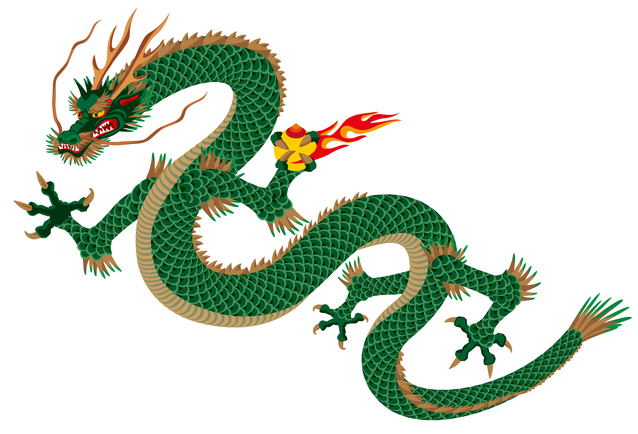

In [15]:
from PIL import Image, ImageFilter

im = Image.open('/content/drive/MyDrive/Colab Notebooks/diveintocode-ml/23.jpg')
im

<start> a person holding a banana in a blue shirt . <end>
-----

【問題3】Kerasで動かしたい場合はどうするかを調査
-----
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

深層学習モデルの相互変換ツールMMdnn
サポートしているフレームワーク
上記githubのサイトに詳細な表や説明があるのでここでは簡単に。

以下のフレームワークでモデルの相互運用が可能になります。
- Caffe 
- Keras
- Tensorflow
- CNTK
- MXNet 
- PyTorch
- CoreML

ONNXへの変換もサポートしていますが、こちらは一方通行で、ONNXから別形式は未対応らしいです。

テスト済みのモデルとしては、
VGG19、Inception v4、ResNet v2、SqueezeNet　あたりは全フレームワークでOKらしいです。

Caffeのサポートが若干弱めですが、MobileNet V2や、NASNetも多くのフレームワークで相互運用が可能.

参考URL:
https://qiita.com/koppe/items/7f85f5411539390c4499

In [ ]:
$ pip install mmdnn

In [ ]:
$ mmdownload -f keras
Support frameworks: {'yolo2', 'inception_v3', 'xception', 'nasnet', 'densenet', 'vgg19', 'mobilenet', 'resnet50', 'vgg16', 'inception_resnet_v2'}

In [ ]:
$ mmdownload -f keras -n inception_v3 -o ./

In [ ]:
$ pip install tensorflow        ←GPU版/CPU版どちらも可
$ pip install keras
$ pip install onnx-tf

In [ ]:
$ mmconvert -sf keras -iw imagenet_inception_v3.h5 -df onnx -om imagenet_inception_v3.onnx

-sf [framework]・・・・変換元(sauce)のフレームワーク
-iw [ファイル]・・・・・入力する重みファイル
-in [ファイル]・・・・・入力するネットワークファイル
-df [framework]・・・・変換先(destination)フレームワーク
-om [ファイル]・・・・・出力先のモデルファイル名

In [ ]:
$ mmtoir -f keras -w imagenet_inception_v3.h5 -o keras_inception_v3

すると、「keras_inception_v3.json」というファイルが生成されます。

このファイルを可視化するためにはクラウド上にて処理を行います。
以下のリンクを開きます。
http://mmdnn.eastasia.cloudapp.azure.com:8080/

以下の画面が出ます。



それ以外にも、coremltools 4.0でPyTorchモデルを変換できるようです。

https://laptrinhx.com/coremltools-4-0depytorchmoderuwo-bian-huansuru-3070697488/
